# House Prices: Advanced Regression Techniques


The [Ames Housing](http://jse.amstat.org/v19n3/decock.pdf) dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset. <br><br>

I challenged myself not to copy/peek at any piece of code from other data science notebooks for this competition (although I googled a heckload of questions, and read many Kaggle discussion threads on this competition). I ended up spending a lot hours trying to figure things out on my own. On the plus side, I ended up learning a whole lot more than I originally thought, which has been very beneficial.

I hope that you find this notebook useful!

Importing libraries.

In [1]:
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import missingno as msno
from sklearn.metrics import mean_squared_error
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from sklearn.inspection import permutation_importance
from IPython.display import display, HTML, display_html
display(HTML("<style>.container { width:100% !important; }</style>"))
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
from lightgbm import LGBMRegressor
import optuna
from mlxtend.regressor import StackingCVRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder,PowerTransformer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression,Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
import math
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
cwd = os.getcwd()
print(cwd)


import gc
gc.enable()

from bokeh.io import output_notebook, show
from bokeh.models import (BasicTicker, ColorBar, ColumnDataSource,LinearColorMapper, PrintfTickFormatter)
from bokeh.plotting import figure
from bokeh.transform import transform


random_state=55

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/working


Running the code below so that IPython shows the entire result of the code I run. 
This becomes helpful to me while visualizing/analyzing high number of plots in the same output.

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

Loading Train and Test data sets.

In [3]:
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

A general overview of the data we need to work with. 
A few lines of code going from high level overview to lower/more detailed levels.

In [4]:
print(f"Train set contains {train.shape[0]} rows,{train.shape[1]} columns. \nTest set contains {test.shape[0]} rows, {test.shape[1]} columns.\n")
print(f"{set(train.columns) - set(test.columns)} are the fields that are IN TRAIN and NOT IN TEST.\n {set(test.columns) - set(train.columns)} are the fields that are IN TEST and NOT IN TRAIN. ")

Train set contains 1460 rows,81 columns. 
Test set contains 1459 rows, 80 columns.

{'SalePrice'} are the fields that are IN TRAIN and NOT IN TEST.
 set() are the fields that are IN TEST and NOT IN TRAIN. 


**Checking to see data types and potential missing values**:

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

**Descriptive statistics:**

In [6]:
display(train.describe().iloc[:,0:18].applymap('{:,g}'.format), train.describe().iloc[:,18:].applymap('{:,g}'.format))

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath
count,"1,460","1,460","1,201","1,460","1,460","1,460","1,460","1,460","1,452","1,460","1,460","1,460","1,460","1,460","1,460","1,460","1,460","1,460"
mean,730.5,56.8973,70.05,"10,516.8",6.09932,5.57534,"1,971.27","1,984.87",103.685,443.64,46.5493,567.24,"1,057.43","1,162.63",346.992,5.84452,"1,515.46",0.425342
std,421.61,42.3006,24.2848,"9,981.26",1.383,1.1128,30.2029,20.6454,181.066,456.098,161.319,441.867,438.705,386.588,436.528,48.6231,525.48,0.518911
min,1,20,21,"1,300",1,1,"1,872","1,950",0,0,0,0,0,334,0,0,334,0
25%,365.75,20,59,"7,553.5",5,5,"1,954","1,967",0,0,0,223,795.75,882,0,0,"1,129.5",0
50%,730.5,50,69,"9,478.5",6,5,"1,973","1,994",0,383.5,0,477.5,991.5,"1,087",0,0,"1,464",0
75%,"1,095.25",70,80,"11,601.5",7,6,"2,000","2,004",166,712.25,0,808,"1,298.25","1,391.25",728,0,"1,776.75",1
max,"1,460",190,313,"215,245",10,9,"2,010","2,010","1,600","5,644","1,474","2,336","6,110","4,692","2,065",572,"5,642",3


,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,"1,460","1,460","1,460","1,460","1,460","1,460","1,460","1,379","1,460","1,460","1,460","1,460","1,460","1,460","1,460","1,460","1,460","1,460","1,460","1,460"
mean,0.0575342,1.56507,0.382877,2.86644,1.04658,6.51781,0.613014,"1,978.51",1.76712,472.98,94.2445,46.6603,21.9541,3.40959,15.061,2.7589,43.489,6.32192,"2,007.82","180,921"
std,0.238753,0.550916,0.502885,0.815778,0.220338,1.62539,0.644666,24.6897,0.747315,213.805,125.339,66.256,61.1191,29.3173,55.7574,40.1773,496.123,2.70363,1.3281,"79,442.5"
min,0,0,0,0,0,2,0,"1,900",0,0,0,0,0,0,0,0,0,1,"2,006","34,900"
25%,0,1,0,2,1,5,0,"1,961",1,334.5,0,0,0,0,0,0,0,5,"2,007","129,975"
50%,0,2,0,3,1,6,1,"1,980",2,480,0,25,0,0,0,0,0,6,"2,008","163,000"
75%,0,2,1,3,1,7,1,"2,002",2,576,168,68,0,0,0,0,0,8,"2,009","214,000"
max,2,3,2,8,3,14,3,"2,010",4,"1,418",857,547,552,508,480,738,"15,500",12,"2,010","755,000"


Let's look at a sample of records...

In [7]:
sample_count=5

display(train.sample(sample_count, random_state=random_state).iloc[:,:30].style.hide_index(),
        train.sample(sample_count ,random_state=random_state).iloc[:,30:60].style.hide_index(),
        train.sample(sample_count, random_state=random_state).iloc[:,60:].style.hide_index())

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation
574,80,RL,76.000000,9967,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,SLvl,7,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,None,0.000000,TA,TA,PConc
1349,20,RL,nan,16196,Pave,nan,IR3,Low,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,5,1998,1998,Gable,CompShg,VinylSd,VinylSd,None,0.000000,Gd,TA,PConc
76,180,RM,21.000000,1596,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,SLvl,4,5,1973,1973,Gable,CompShg,CemntBd,CmentBd,None,0.000000,TA,TA,CBlock
129,60,RL,69.000000,7590,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,NAmes,PosN,Norm,1Fam,2Story,6,5,1966,1966,Gable,CompShg,VinylSd,VinylSd,BrkFace,266.000000,TA,TA,CBlock
752,60,RL,nan,7750,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,RRAn,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,None,0.000000,Gd,TA,PConc


BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt
Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Ex,Y,SBrkr,774,656,0,1430,0,0,2,1,3,1,TA,8,Typ,1,TA,BuiltIn,2000.000000
Gd,TA,Gd,GLQ,1443,Unf,0,39,1482,GasA,Ex,Y,SBrkr,1494,0,0,1494,1,0,2,0,3,1,Gd,5,Typ,1,Fa,Attchd,1998.000000
Gd,TA,Gd,GLQ,462,Unf,0,0,462,GasA,TA,Y,SBrkr,526,462,0,988,1,0,1,0,2,1,TA,5,Typ,0,nan,BuiltIn,1973.000000
TA,TA,No,BLQ,512,Unf,0,148,660,GasA,TA,Y,SBrkr,660,688,0,1348,0,0,1,1,3,1,TA,6,Typ,1,Fa,Attchd,1966.000000
Gd,TA,No,Unf,0,Unf,0,660,660,GasA,Ex,Y,SBrkr,660,660,0,1320,0,0,2,1,3,1,Gd,6,Typ,0,nan,Attchd,2003.000000


GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
RFn,2,400,TA,TA,Y,100,0,0,0,0,0,nan,nan,nan,0,12,2007,WD,Normal,170000
RFn,2,514,TA,TA,Y,402,25,0,0,0,0,nan,nan,nan,0,8,2007,WD,Normal,215000
Unf,1,297,TA,TA,Y,120,101,0,0,0,0,nan,GdWo,nan,0,11,2009,WD,Normal,91000
RFn,2,453,TA,TA,Y,188,108,0,0,0,0,nan,nan,nan,0,7,2006,WD,Normal,155000
Fin,2,400,TA,TA,Y,0,48,0,0,0,0,nan,nan,nan,0,8,2007,WD,Normal,162000


Extracting the ID since we need to use it for submission later.<br>
I also concatenate train and test sets into one dataframe.

In [8]:
Id = 'Id' 

submission_ID = test.loc[:,Id]

train.drop(Id, axis=1, inplace=True)
test.drop(Id, axis=1, inplace=True)

# For identification purposes
train.loc[:,'Train'] = 1
test.loc[:,'Train'] = 0

test['SalePrice'] = 0

stacked_DF = pd.concat([train,test], ignore_index=True)

# Target Variable Distribution - Univariate

Let's look at the target variable distribution. I am creating an additional plot to show how log transformation impacts the variable since it's skewed.

Text(0.5, 1.0, 'Distribution of SalePrice (Log Transformed)')

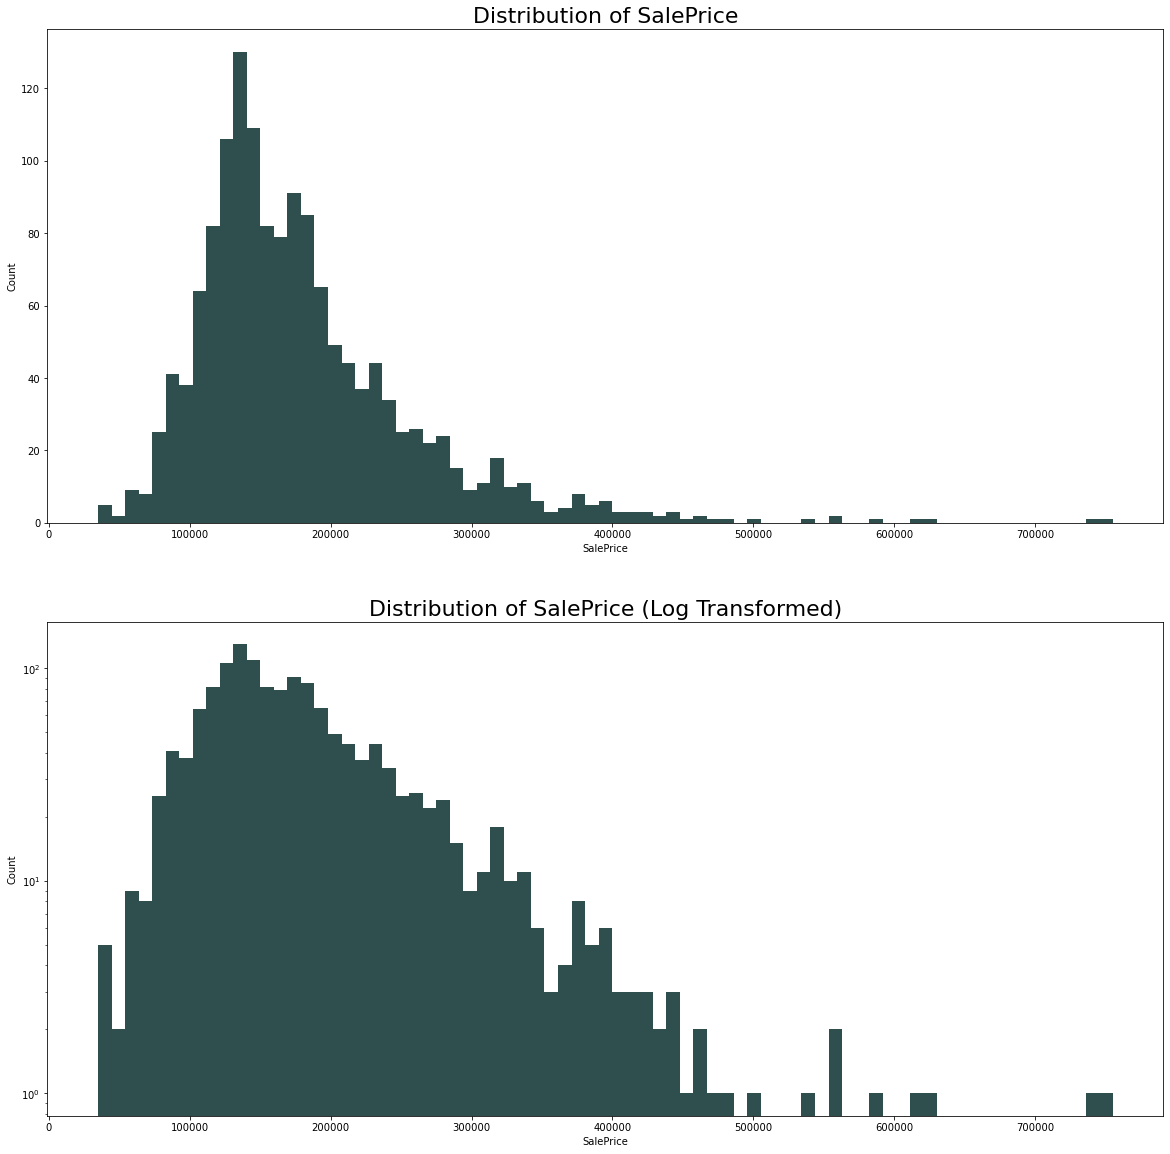

In [9]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=[20,20])

params = {
         'axes.labelsize': 20,
         'axes.titlesize': 22,
         'xtick.labelsize':16,
         'ytick.labelsize':16
}
plt.rcParams.update(params)

ax[0].set_xlabel('SalePrice')
ax[0].set_ylabel('Count')

ax[1].set_xlabel('SalePrice')
ax[1].set_ylabel('Count')


plot_X = stacked_DF.loc[stacked_DF['Train']==1]['SalePrice']

plot = ax[0].hist(plot_X, bins=75, log=False, color='darkslategrey')
plot = ax[1].hist(plot_X, bins=75, log=True, color='darkslategrey')

ax[0].set_title('Distribution of SalePrice')
ax[1].set_title('Distribution of SalePrice (Log Transformed)')

It looks like log transformation will be relatively successful to normalize the target variable. 
Even after the log transformation, I see some outliers on the right hand side of the spectrum; though I am not sure if there's anything I can do for those.



# Bivariate Analyis

I will first plot a few numeric variables against the target variable, then I will do the same for categorical variables.
What I am looking for is correlation, outliers and the distribution of the target variable with respect to dependent variables.<br>
Scatter Plot is good for numeric variable visualization. For categorical variables, I will use Box-plot.

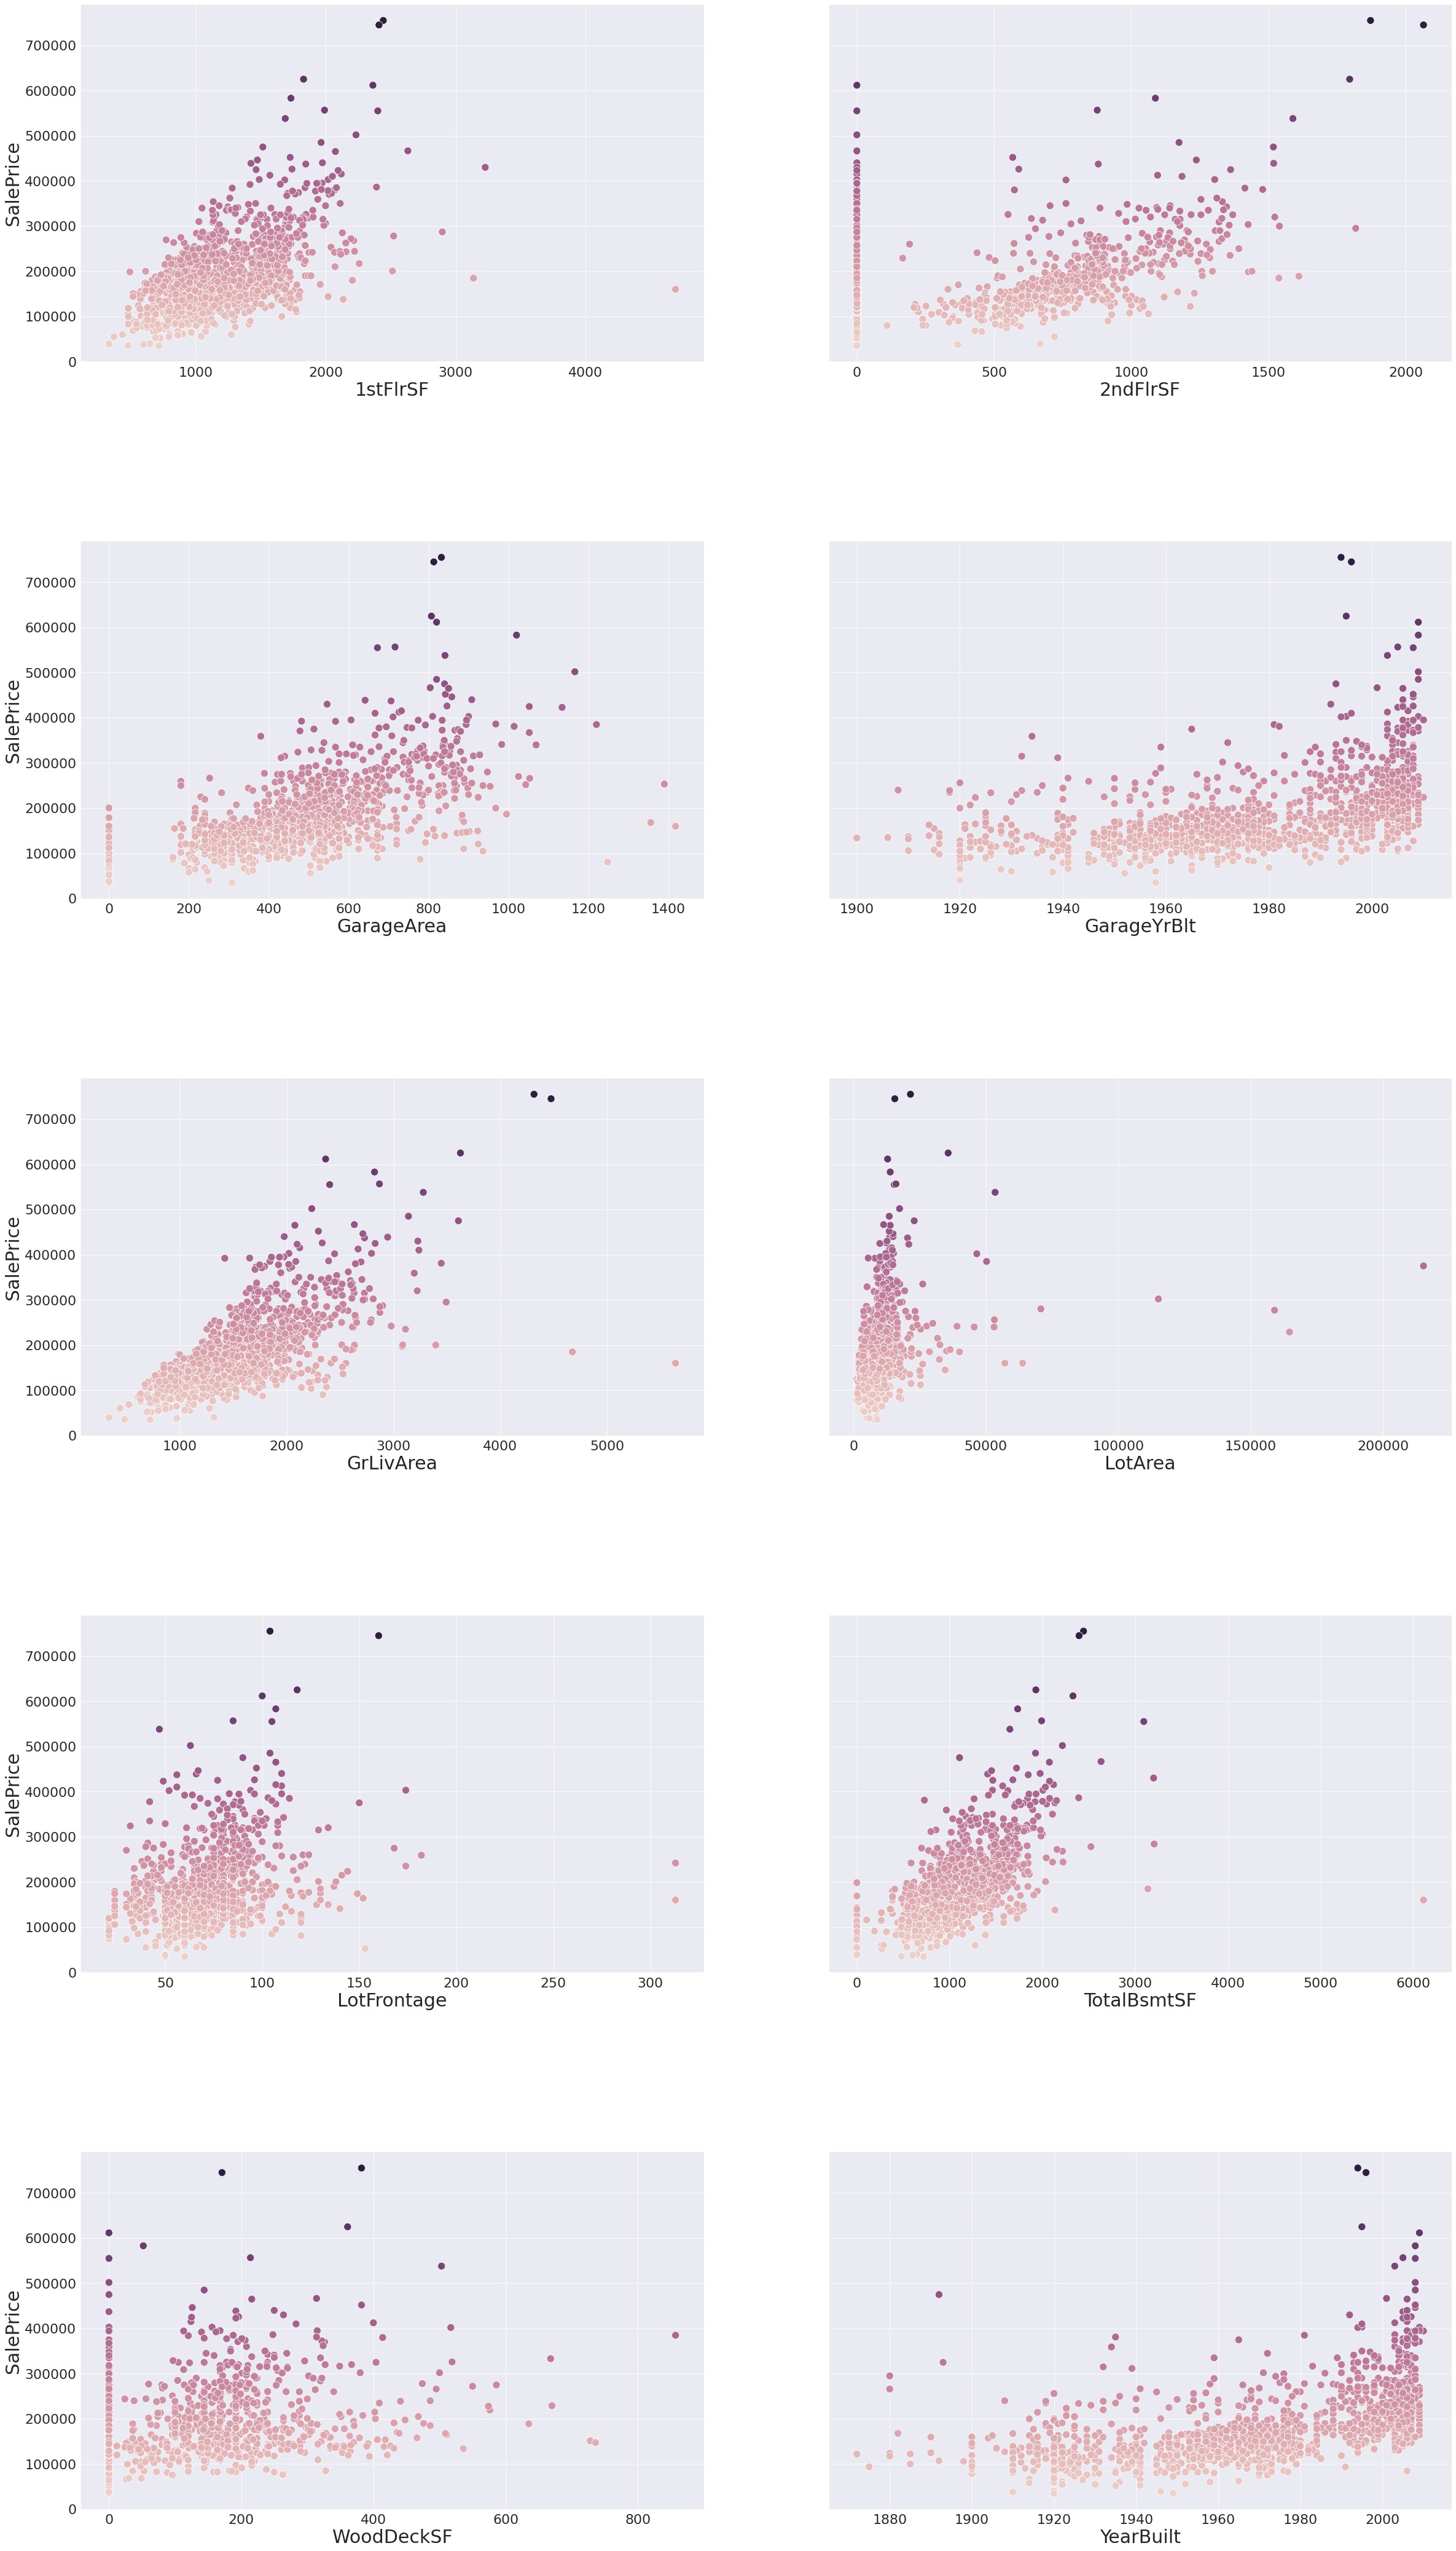

In [10]:
sns.set_style("darkgrid")
params = {
         'axes.labelsize': 30,
         'xtick.labelsize':22,
         'ytick.labelsize':22
}
plt.rcParams.update(params)

features_to_viz = ['GrLivArea','YearBuilt', 'WoodDeckSF', 'LotArea', 'GarageArea',
                   '1stFlrSF','2ndFlrSF','TotalBsmtSF','LotFrontage','GarageYrBlt']

# Because there are a lot of variables to vizualize, 
# sorting them helps me keep track of which variable is where
features_to_viz = sorted(features_to_viz)

ncols = 2
nrows = math.ceil(len(features_to_viz)/ncols)
unused = (nrows*ncols) - len(features_to_viz)

figw= ncols*20
figh= nrows*15


fig, ax = plt.subplots(nrows,ncols, sharey=True, figsize=(figw,figh))
fig.subplots_adjust(hspace=.5)
ax = ax.flatten()

for i in range(unused,0,-1):
    fig.delaxes(ax[-i])



for n, col in enumerate(features_to_viz):
    if (n%2!=0):
        ax[n].yaxis.label.set_visible(False)
    ax[n].set_xlabel(col)
    ax[n].set_ylabel('SalePrice')
    sns.scatterplot(x=col , y='SalePrice', data=stacked_DF.loc[stacked_DF['Train']==1], 
                    hue='SalePrice', s=150, legend=False, ax=ax[n])

plt.show()

**Looking at the graphs above, I find a few things to note:**

* GrLivArea, YrBuilt, LotArea and a few others have linear-like relationship with the target variable.
* There are a few outliers. Data source's notes mention these outliers, and recommends to remove them. I, however, don't like the idea of removing records as we're already working with limited amount of samples.

Moving on with the categorical bivariate analysis.

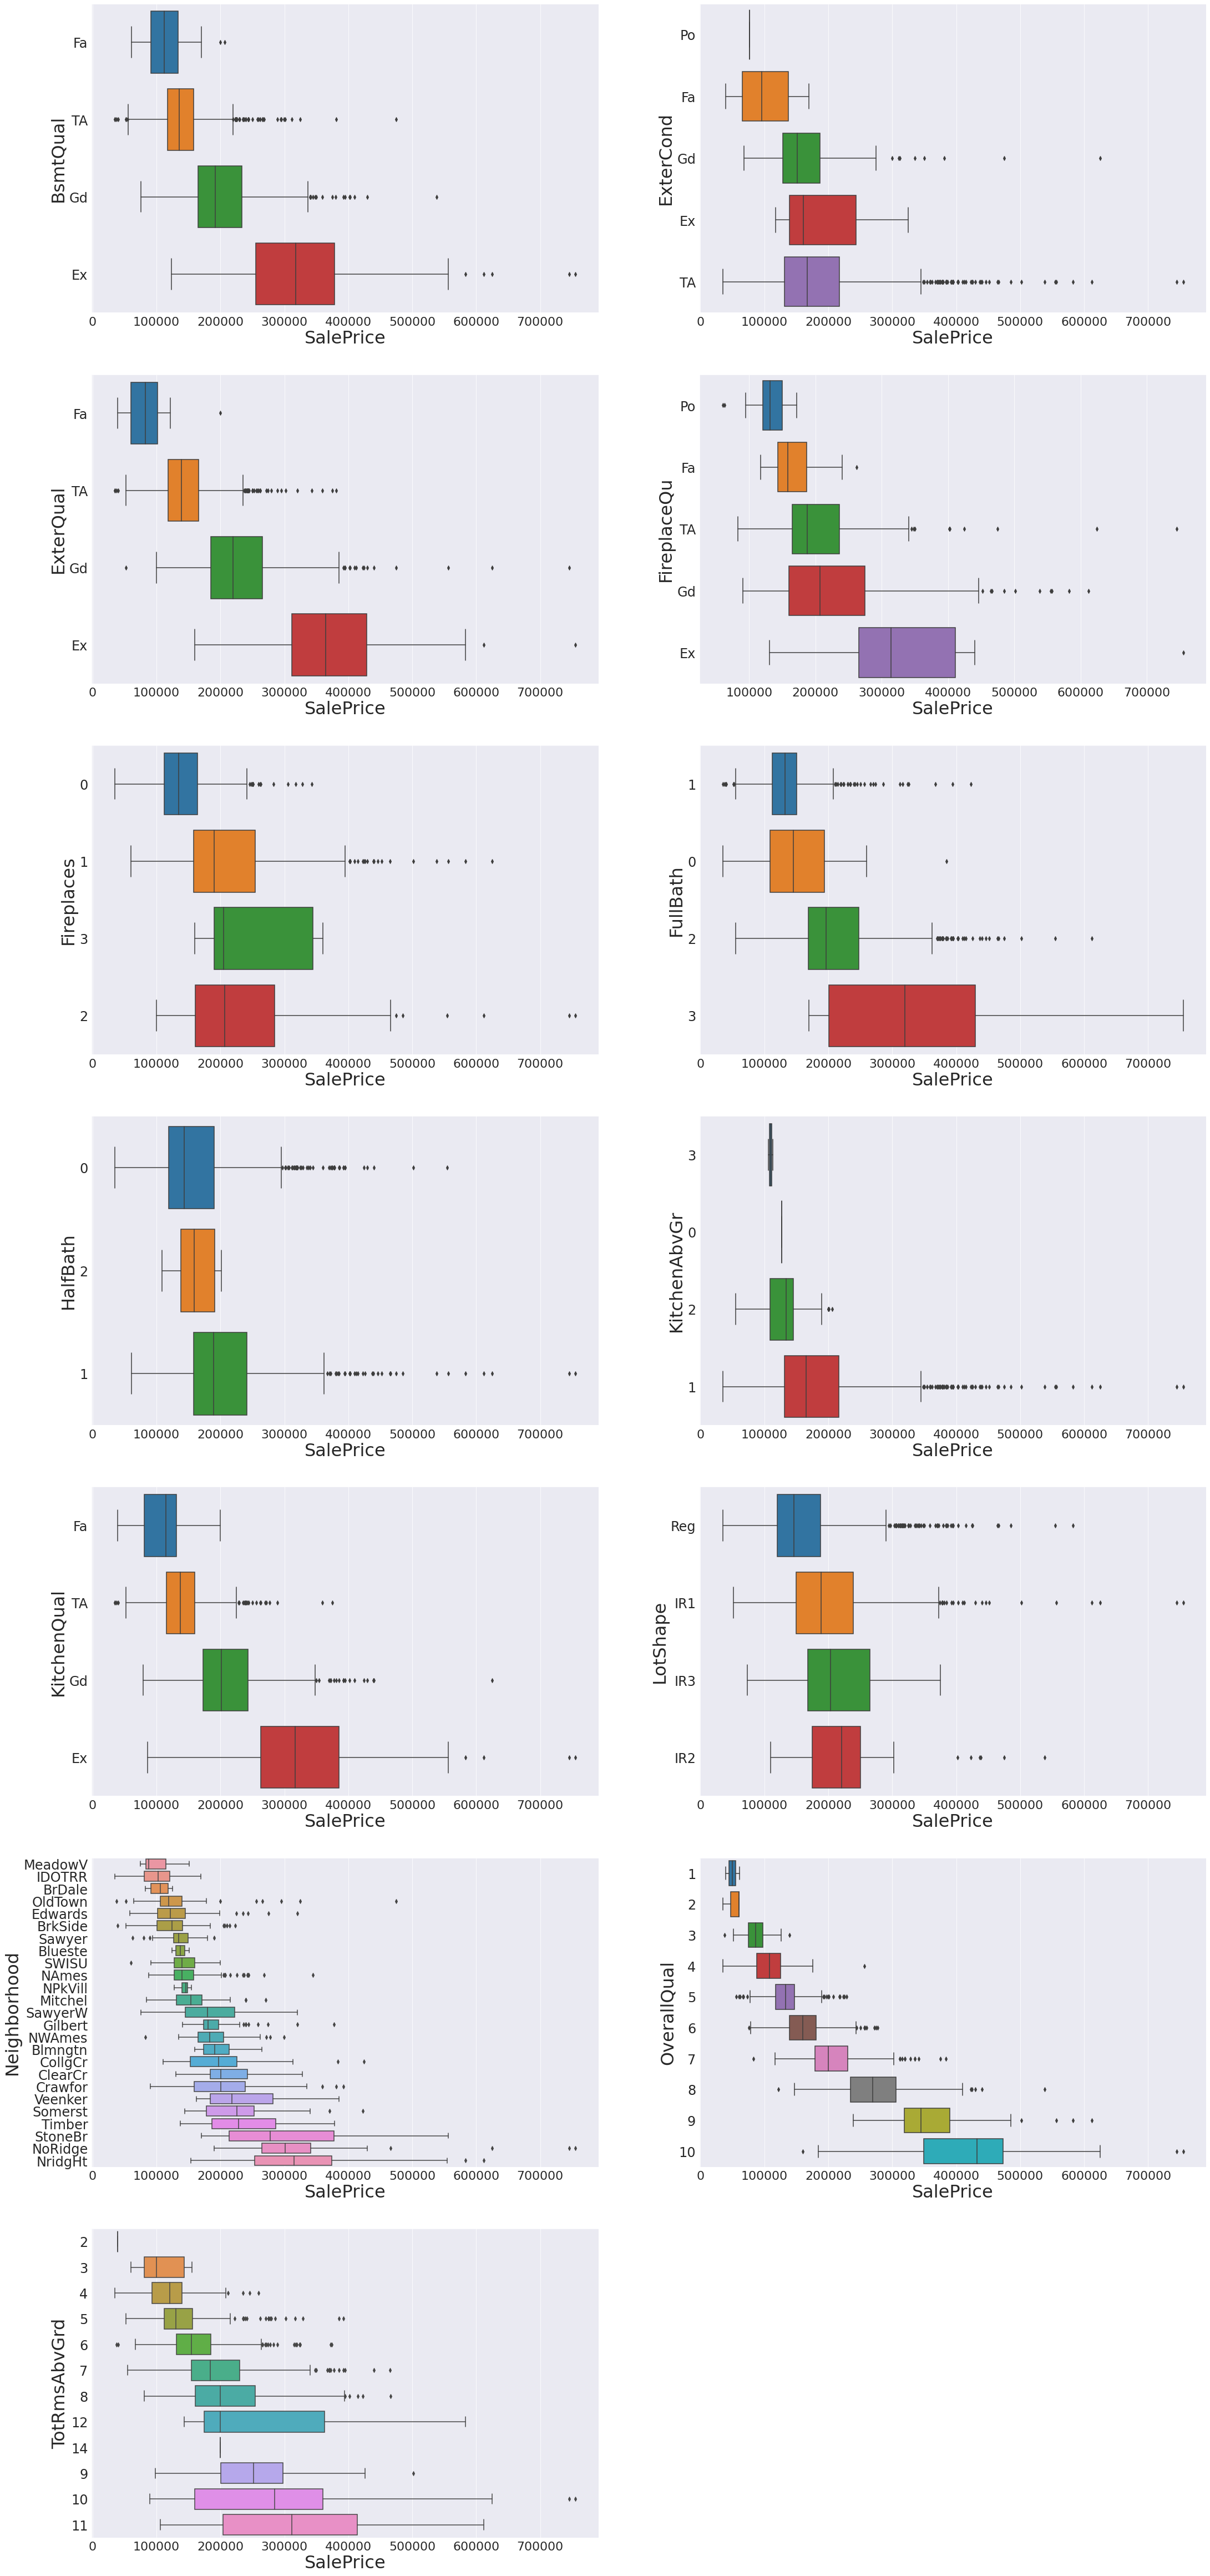

In [11]:
sns.set_style("darkgrid")
params = {
         'axes.labelsize': 32,
         'xtick.labelsize':22,
         'ytick.labelsize':24
}
plt.rcParams.update(params)

features_to_viz = ['Neighborhood','BsmtQual','ExterQual','FireplaceQu','ExterCond',
                   'KitchenQual','LotShape','OverallQual', 'FullBath','HalfBath',
                   'TotRmsAbvGrd','Fireplaces','KitchenAbvGr']

# Because there are a lot of variables to vizualize, 
# sorting them helps me keep track of which var is where
features_to_viz = sorted(features_to_viz)


ncols = 2
nrows = math.ceil(len(features_to_viz)/ncols)
unused = (nrows*ncols) - len(features_to_viz)


figw, figh= ncols*18, nrows*12

fig, ax = plt.subplots(nrows,ncols, figsize=(figw,figh))
fig.subplots_adjust(hspace=0.2,wspace=0.2)
ax = ax.flatten()
for i in range(unused,0,-1):
    fig.delaxes(ax[-i])



for n, col in enumerate(features_to_viz):
    ordering = stacked_DF.loc[stacked_DF['Train']==1].groupby(by=col)['SalePrice'].median().sort_values().index
    sns.boxplot(x='SalePrice',y=col, data=stacked_DF.loc[stacked_DF['Train']==1], order=ordering, ax=ax[n], orient='h')


plt.show()

* OverallQual impacts SalePrice exponentially!
* Neighborhood matters. Features regarding quality also matter.
* **The more irregular the lot shape is, the higher the Sale Price seems**. This was a surprise to me. That being said, I can relate irregular lot shape to architectural originality, which costs money. Regular lot shape relates to just regular homes that more of us can afford. But this is only a guess.

# Missing Values

I will first look at raw missing counts. Then, I will visualize the dataframe to see if there is any relation between missing records/features. Such relation would impact my imputing strategy for those records.

In [12]:
print("Missing Value Counts in Train DF")
stacked_DF[stacked_DF['Train']==1].isna().sum()[stacked_DF[stacked_DF['Train']==1].isna().sum()>0].sort_values(ascending=False)

Missing Value Counts in Train DF


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [13]:
print("Missing Values in Test DF")
stacked_DF[stacked_DF['Train']==0].isna().sum()[stacked_DF[stacked_DF['Train']==0].isna().sum()>0].sort_values(ascending=False)

Missing Values in Test DF


PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageCond        78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

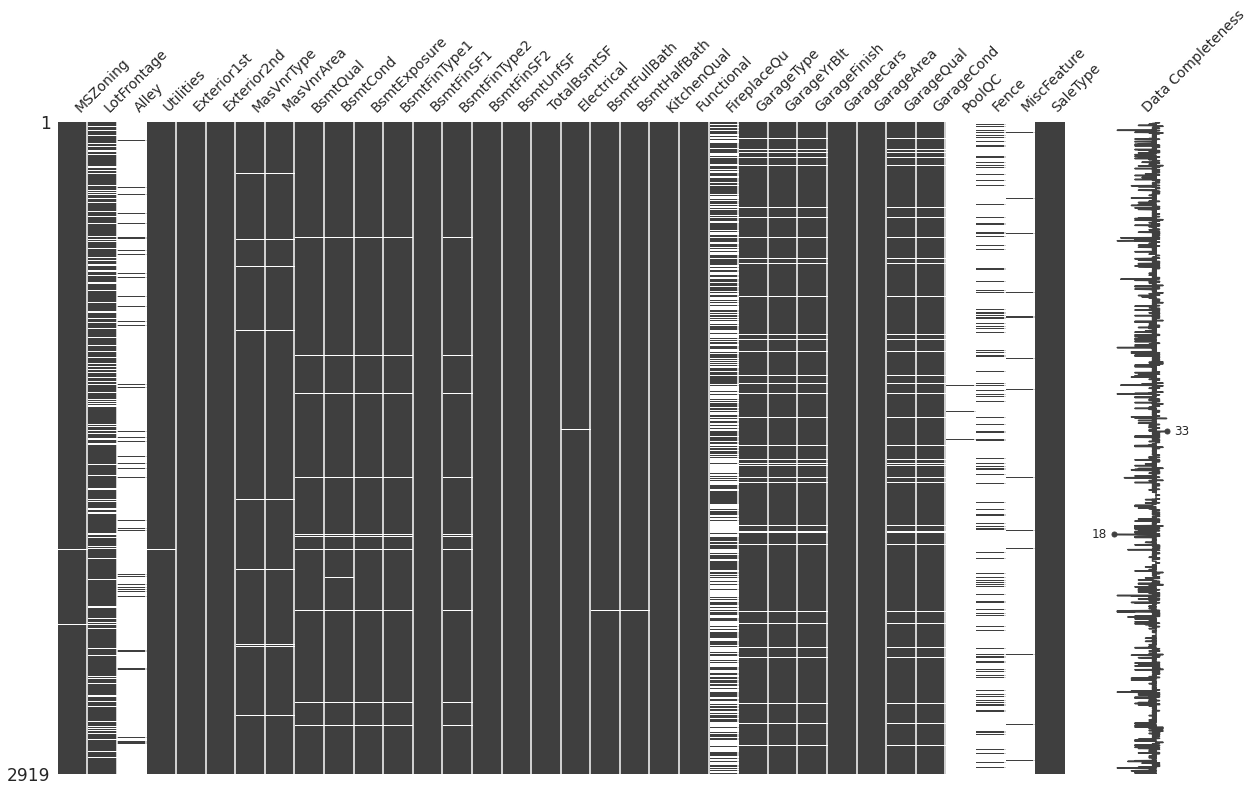

In [14]:
# Check missing records in train set
na_cols = (stacked_DF.isna().sum()[stacked_DF.isna().sum()>0]).index
mat = msno.matrix(stacked_DF.loc[:,na_cols], labels=True, figsize=(20,12), fontsize=14,inline=False)

Looking at the figure above and reading data descriptions provided by data source, it seems like missing records **mostly** indicate the non-existance of a feature. <br> 
For example, if basement condition is missing, it means that the record belongs to a house with no basement. Similarly, if PoolQC is missing, that means the house has no pool. However, there are a few exceptions to these rules.<br><br>
To keep things simple, I will mostly employ mass imputing strategy as opposed to deal with exceptions.

# Imputing Missing Values and Feature Engineering

Below I impute missing records.

In [15]:
# Assuming Neighborhood and MSZoning are related. 
lookup = stacked_DF.loc[stacked_DF['Train']==1].groupby(by='Neighborhood')['MSZoning'].agg(pd.Series.mode)
stacked_DF['MSZoning'] = stacked_DF['MSZoning'].fillna(stacked_DF['Neighborhood'].map(lookup))

# Assuming KitchenQual and OverallQual are related. 
lookup = stacked_DF.loc[stacked_DF['Train']==1].groupby(by='OverallQual')['KitchenQual'].agg(pd.Series.mode)
stacked_DF['KitchenQual'] = stacked_DF['KitchenQual'].fillna(stacked_DF['OverallQual'].map(lookup))


# For these features I replace nan with a string indicator: "missing"
cols_na_to_missing = {
    'Alley','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFullBath','BsmtQual',  
    'Fence', 'FireplaceQu',  'GarageCond','GarageFinish', 'GarageQual', 
    'GarageType', 'MasVnrType', 'MiscFeature', 'PoolQC', 'BsmtFinType2',
}

# For these features I replace nan with the integer 0
cols_na_to_zero = {
#     'BsmtUnfSF','GarageArea','GarageCars', 'TotalBsmtSF','MasVnrArea', 
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath','BsmtHalfBath','GarageYrBlt'
}

# For these features I replace nan with the mode of the feature the record is missing.
cols_na_to_mode = {'Functional','Electrical','Utilities',
                   'Exterior1st','Exterior2nd','SaleType'}


for col in cols_na_to_missing:
    stacked_DF[col] = stacked_DF[col].astype(object).fillna("Missing")

for col in cols_na_to_zero:
    stacked_DF[col] = stacked_DF[col].astype(object).fillna(0)    
    
for col in cols_na_to_mode:
    stacked_DF[col] = stacked_DF[col].astype(object).fillna(stacked_DF.loc[stacked_DF['Train']==1,col].mode()[0])
    




# Imputing remaining missing values with the help of iterative imputer.
num_features = stacked_DF.drop(columns=['Train']).select_dtypes("number").columns
imputer = IterativeImputer(RandomForestRegressor(max_depth=8),n_nearest_features=10, max_iter=10, random_state=random_state)
stacked_DF.loc[stacked_DF['Train']==1,num_features] = imputer.fit_transform(stacked_DF.loc[stacked_DF['Train']==1,num_features].values)
stacked_DF.loc[stacked_DF['Train']==0,num_features] = imputer.transform(stacked_DF.loc[stacked_DF['Train']==0,num_features].values)

Below I establish synthetic features via feature crossing and value mapping. These new features sometimes allow models capture patterns that they wouldn't be able to capture from individual features.<br> More about feature crossing -> https://developers.google.com/machine-learning/crash-course/feature-crosses/video-lecture

In [16]:
stacked_DF['WarmSeason'] = np.where(stacked_DF['MoSold'].isin([10,11,12,1,2,3]),0,1)
stacked_DF['SqFtPerRoom'] = stacked_DF['GrLivArea']/(stacked_DF['TotRmsAbvGrd']+stacked_DF['FullBath']+stacked_DF['HalfBath']+stacked_DF['KitchenAbvGr'])

# Converting MSSubClass to categorical
stacked_DF['MSSubClass'] = stacked_DF['MSSubClass'].astype(str)


# Below I establish ranking among categories within a handful of features, 
# Ranking is based on the median SalePrice they show for each category.
cateogies_to_rank = [
    'BsmtQual','ExterQual','ExterCond','Exterior1st','FireplaceQu', 'GarageCond','GarageQual',
    'Heating','Fence','HeatingQC','OverallQual','OverallCond','HouseStyle','KitchenQual','LotShape',
    'BsmtCond','MSSubClass','Neighborhood','SaleCondition','SaleType','MasVnrType','ExterQual'
]

for col in cateogies_to_rank:
    rank = np.array(range(0,len(stacked_DF.loc[stacked_DF['Train']==1,col].unique())))
    field_val = stacked_DF.loc[stacked_DF['Train']==1].groupby(by=col)['SalePrice'].median().sort_values().index
    rankval_mapping = dict(zip(field_val,rank))
    stacked_DF[col+"_ranking"] = (stacked_DF[col].map(rankval_mapping, na_action='ignore'))

# There is an MSSubClass category in test set but not in train. This creates an nan record during ranking.
# I impute that nan record with the mode of the field (based on the train set)
stacked_DF.loc[stacked_DF['MSSubClass_ranking'].isna(),'MSSubClass_ranking'] = 10


# I combine underrepresented categories under one umbrella and/or with another category in the same field
ext2_map = {
    'AsphShn':'Oth1',
    'CBlock':'Oth1',
    'CmentBd':'Oth2',
    'Other':'Oth2'
}
roofmatl_map={
    'Roll':'Oth1',
    'ClyTile':'Oth1',
    'Metal':'Oth1',
    'CompShg':'Oth1',
    'Membran':'Oth2',
    'WdShake':'Oth2'
}

cond2_map = {
    'PosA':'Pos',
    'PosN':'Pos',
    'RRAe':'Norm',
    'RRAn':'Norm'
}


stacked_DF['Exterior2nd'] = stacked_DF['Exterior2nd'].map(ext2_map).fillna(stacked_DF['Exterior2nd'])
stacked_DF['RoofMatl'] = stacked_DF['RoofMatl'].map(roofmatl_map).fillna(stacked_DF['RoofMatl'])
stacked_DF['Condition2'] = stacked_DF['Condition2'].map(cond2_map).fillna(stacked_DF['Condition2'])

# Below I establish new features, mainly via feature crossing
stacked_DF['QualCond'] = stacked_DF['OverallQual_ranking']*stacked_DF['OverallCond_ranking']
stacked_DF['HighQualSF'] = stacked_DF['1stFlrSF'] + stacked_DF['2ndFlrSF']
stacked_DF['HoodNExtCond'] = stacked_DF['Neighborhood_ranking']*stacked_DF['ExterCond_ranking']
stacked_DF['HoodNPrivacy'] = stacked_DF['Neighborhood_ranking']*stacked_DF['Fence_ranking']
stacked_DF['AreaOverallQualCond'] = stacked_DF['HighQualSF']*stacked_DF['OverallQual_ranking']*stacked_DF['OverallCond_ranking']
stacked_DF['KitchenQCHighQualSF'] = stacked_DF['HighQualSF']*stacked_DF['KitchenQual_ranking']
stacked_DF['HoodNOverallQual'] = stacked_DF['Neighborhood_ranking']*stacked_DF['OverallQual_ranking']
stacked_DF['HoodNMasVnrType'] = stacked_DF['Neighborhood_ranking']*stacked_DF['MasVnrType_ranking']
stacked_DF['HoodNKitchenQual'] = stacked_DF['Neighborhood_ranking']*stacked_DF['KitchenQual_ranking']
stacked_DF['HoodNCond1'] = stacked_DF['Neighborhood_ranking']*stacked_DF['Condition1']
stacked_DF['HoodNCond2'] = stacked_DF['Neighborhood_ranking']*stacked_DF['Condition2']
stacked_DF['HoodNPorch'] = stacked_DF['Neighborhood_ranking']*(stacked_DF['3SsnPorch']+stacked_DF['EnclosedPorch']+stacked_DF['OpenPorchSF'])

stacked_DF['Age_YrBuilt'] = stacked_DF['YrSold'] - stacked_DF['YearBuilt']
stacked_DF['Age_YrRemod'] = stacked_DF['YrSold'] - stacked_DF['YearRemodAdd']
stacked_DF['Age_Garage'] = stacked_DF['YrSold'] - stacked_DF['GarageYrBlt']
stacked_DF['Remodeled'] = stacked_DF['YearBuilt']!=stacked_DF['YearRemodAdd']
stacked_DF['Age_YrBuilt'] = stacked_DF['Age_YrBuilt'].apply(lambda x: 0 if x <0 else x)
stacked_DF['Age_YrRemod'] = stacked_DF['Age_YrRemod'].apply(lambda x: 0 if x <0 else x)
stacked_DF['Age_Garage'] = stacked_DF['Age_Garage'].apply(lambda x: 0 if x <0 else x)

sqft_price_table = stacked_DF.loc[stacked_DF['Train']==1].groupby(by='Neighborhood')['SalePrice','GrLivArea'].agg(pd.Series.sum)
sqft_price_table['AvgPricePerSqFt'] = sqft_price_table['SalePrice']/sqft_price_table['GrLivArea']
sqft_price_table.drop(columns=['SalePrice','GrLivArea'],inplace=True)
stacked_DF['AvgPricePerSqFtPerHood'] = stacked_DF['Neighborhood'].map(sqft_price_table.to_dict()['AvgPricePerSqFt'])

# Dropping a handful of features as there are other variables that are perfectly correlated to these
# I did trial and error here based on the impact of removing features on RMSE.
stacked_DF.drop(columns=['GarageYrBlt','Utilities'], inplace=True)

# Would like to visualize some of the newly established features to see their relationship with target.
# Hoping to see some correlation
cols_to_viz = ['HighQualSF','KitchenQCHighQualSF','AreaOverallQualCond','HoodNOverallQual','HoodNMasVnrType','HoodNKitchenQual']

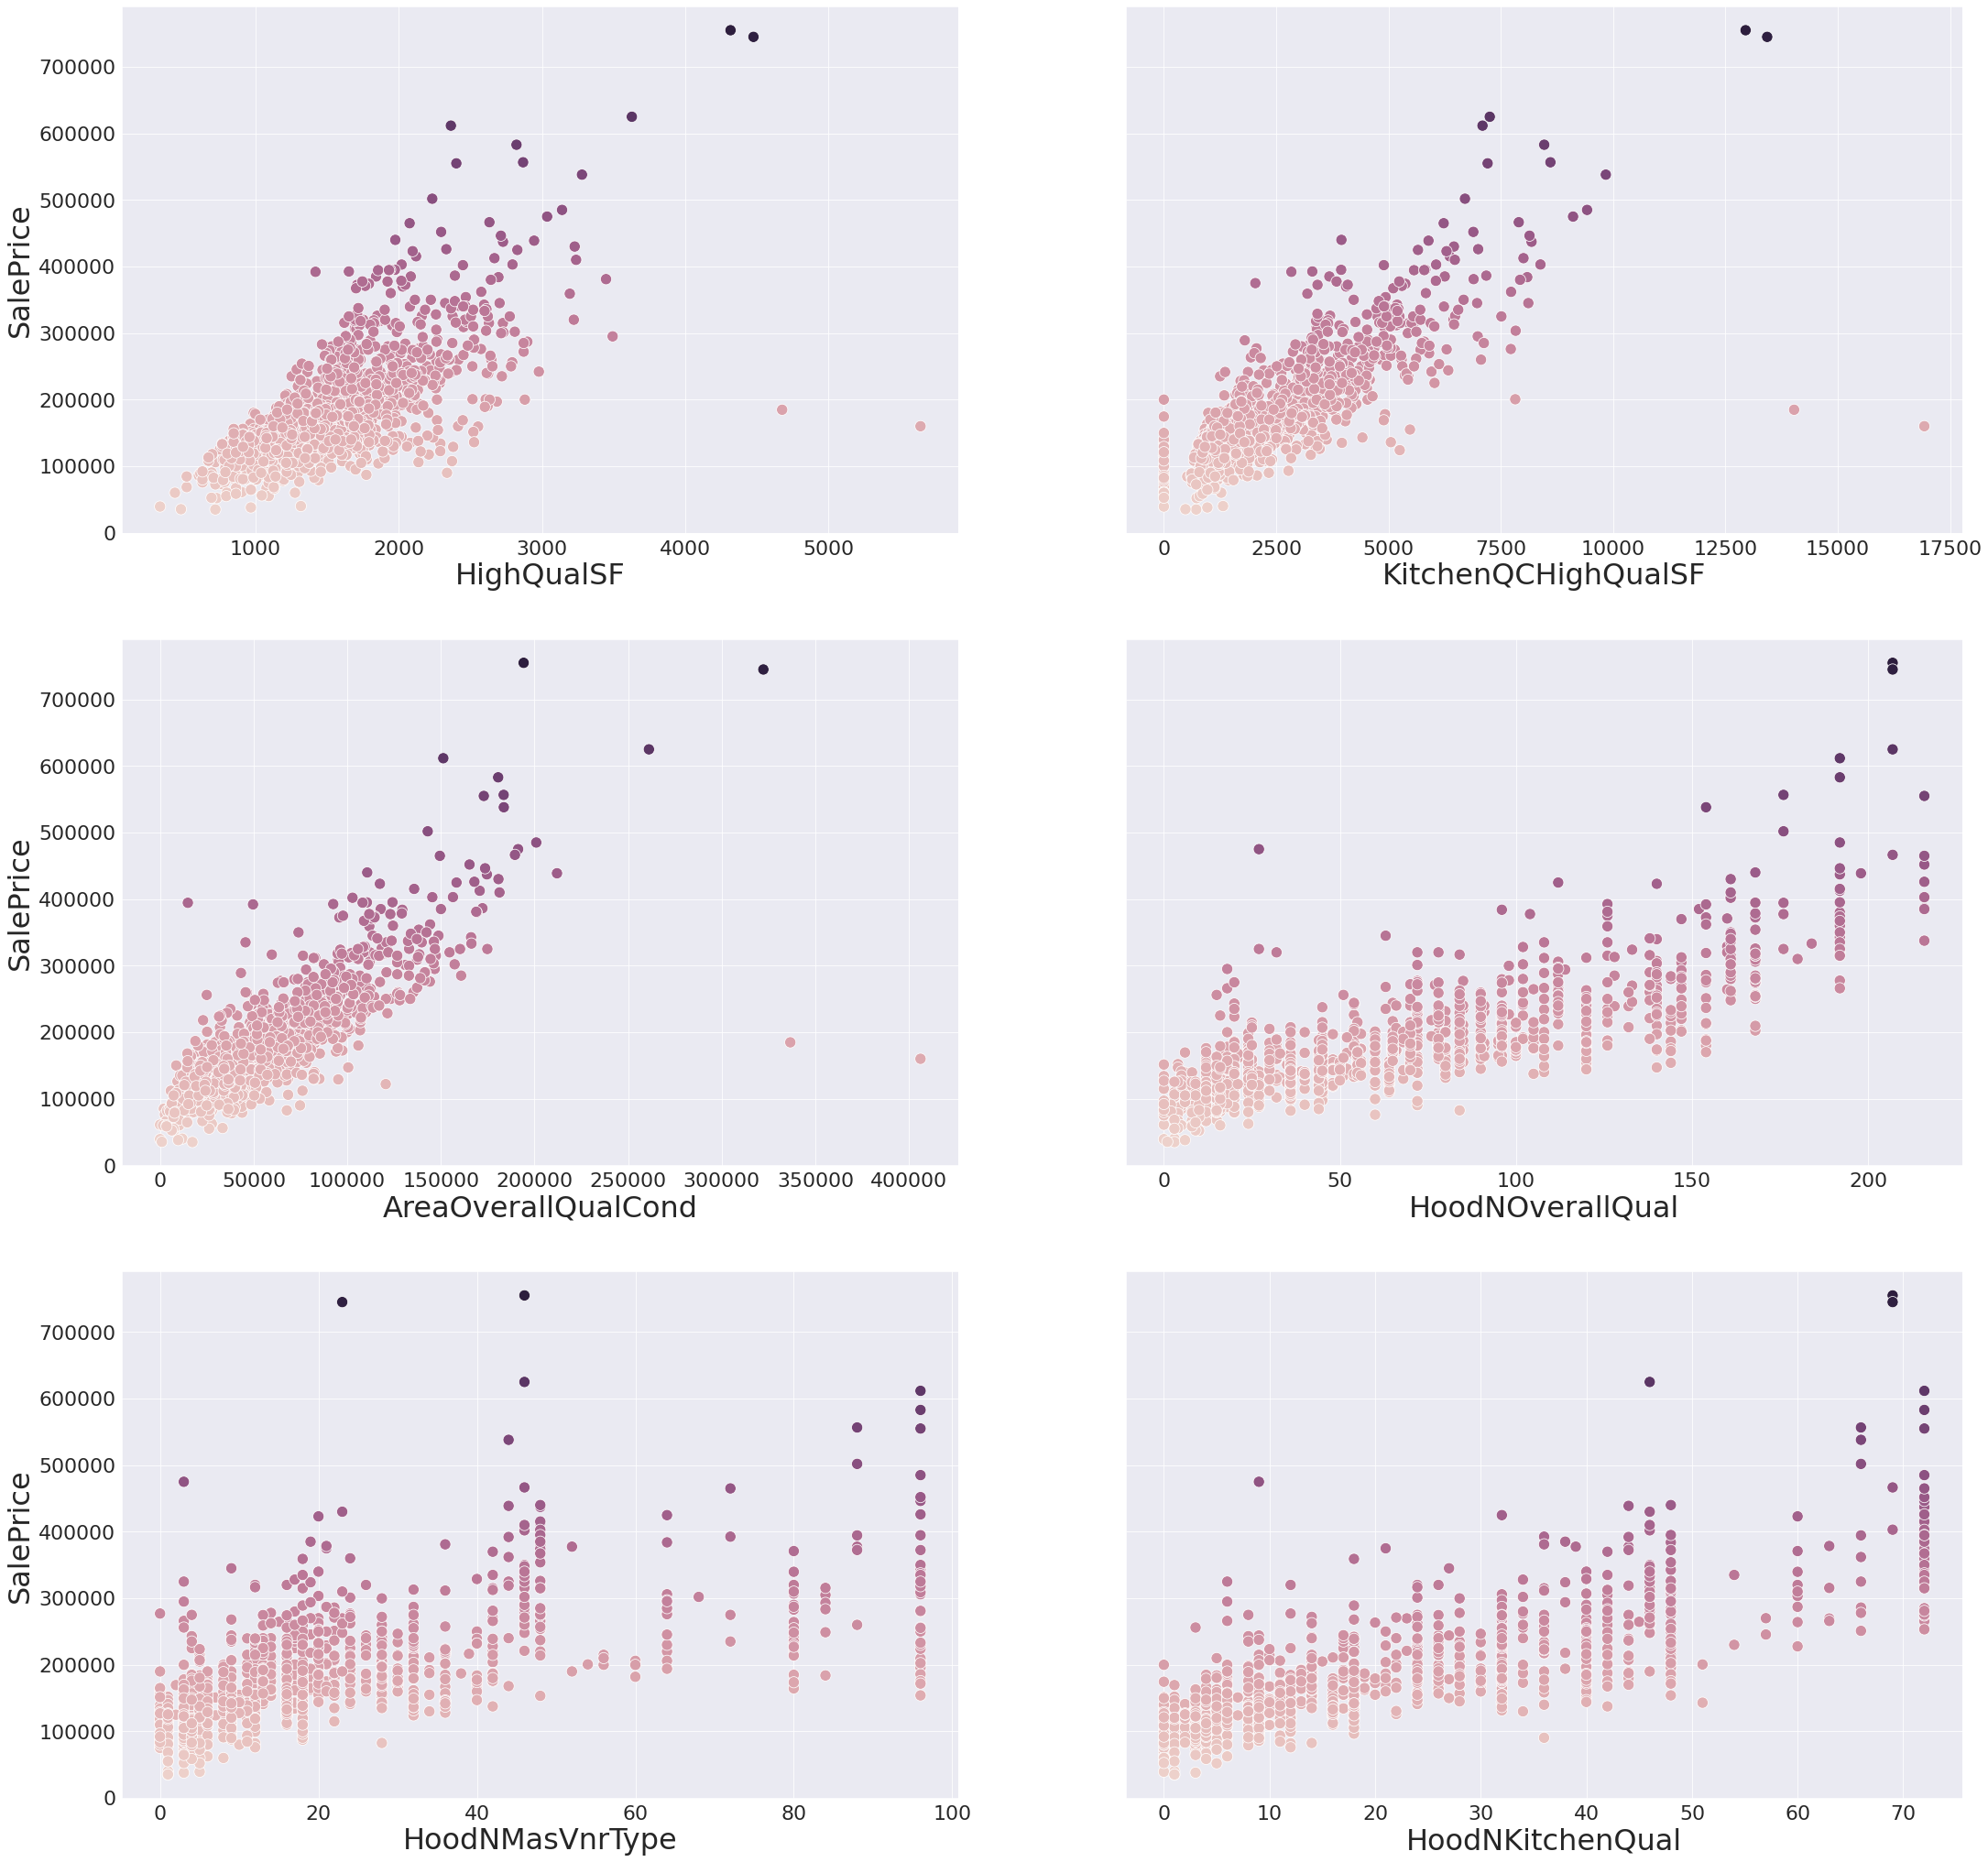

In [17]:
sns.set_style("darkgrid")
params = {
         'axes.labelsize': 32,
         'xtick.labelsize':22,
         'ytick.labelsize':22
}
plt.rcParams.update(params)


ncols = 2
nrows = math.ceil(len(cols_to_viz)/ncols)
unused = (nrows*ncols) - len(cols_to_viz)


figw, figh= ncols*18, nrows*12

fig, ax = plt.subplots(nrows,ncols, sharey=True, figsize=(figw,figh))
fig.subplots_adjust(hspace=0.2,wspace=0.2)
ax = ax.flatten()
for i in range(unused,0,-1):
    fig.delaxes(ax[-i])


for n, col in enumerate(cols_to_viz):
    if (n%2!=0):
        ax[n].yaxis.label.set_visible(False)
    ax[n].set_xlabel(col)
    ax[n].set_ylabel('SalePrice')
    sns.scatterplot(x=col,y='SalePrice', data=stacked_DF.loc[stacked_DF['Train']==1], 
                    hue='SalePrice',s=150, legend=False, ax=ax[n])
    
plt.show()

# Correlation Heatmap

Let's look at a heatmap that shows correlations between our variables. I want to see a lot of red squares next to SalePrice. That means we have a lot of independent variables correlating with the target variable.<br><br> In an ideal scenario, we wouldn't see high correlation **among independent variables**; however, that's not the case. I trust our models will pick features that are important to them, without us needing to deal with multicollinearity.<br><br>

As useful as they are, heatmaps get messy pretty quickly dealing with high number of variables. Bokeh provides interactive plotting, which means I can hover over a red square to find out which two features have high correlation. Otherwise I'd have to figure those out looking at tick labels. 

In [18]:
output_notebook()

df_to_viz = stacked_DF[stacked_DF['Train']==1].drop(columns='Train')

xcorr =  abs(df_to_viz.corr())
xcorr.index.name = 'Feature1'
xcorr.columns.name = 'Feature2'

df = pd.DataFrame(xcorr.stack(), columns=['Corr']).reset_index()


source = ColumnDataSource(df)

colors = ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]


mapper = LinearColorMapper(palette=colors, low=df.Corr.min(), high=df.Corr.max())

f1 = figure(plot_width=1200, plot_height=1000, title="Correlation Heat Map",
           x_range=list(sorted(xcorr.index)), y_range=list(reversed(sorted(xcorr.columns))),
           toolbar_location=None, tools="hover", x_axis_location="above")

f1.rect(x="Feature2", y="Feature1", width=1, height=1, source=source,line_color=None, fill_color=transform('Corr', mapper))

color_bar = ColorBar(color_mapper=mapper, location=(0, 0),
                     ticker=BasicTicker(desired_num_ticks=len(colors)),
                     formatter=PrintfTickFormatter(format="%d%%"))
f1.add_layout(color_bar, 'right')

f1.hover.tooltips = [
    ("Feature1", "@{Feature1}"),
    ("Feature2", "@{Feature2}"),
    ("Corr", "@{Corr}{1.1111}"),
]

f1.axis.axis_line_color = None
f1.axis.major_tick_line_color = None
f1.axis.major_label_text_font_size = "10px"
f1.xaxis.major_label_text_font_size = '12px'
f1.axis.major_label_standoff = 2
f1.xaxis.major_label_orientation = 1.0

show(f1)

Loading BokehJS ...

**Dealing with highly skewed variables**

I will first identify any variable with skew coefficient greater than 5, then I will apply yeo-johnson transformation on them.<br><br> Generally speaking, any variable with absolute skew coefficient greater than 1(and abs kurtosis greater than 2) is considered a red flag. That being said, when I apply transformation based on +1/-1 threshold, the RMSE icreases significantly, and accuracy reduces (as well as the LB positon). With trial an error, I settled on threshold of 5.

In [19]:
stacked_DF[stacked_DF['Train']==1].skew()[abs(stacked_DF[stacked_DF['Train']==1].skew())>5]

LotArea           12.21
LowQualFinSF       9.01
3SsnPorch         10.30
PoolArea          14.83
MiscVal           24.48
Heating_ranking   -9.59
dtype: float64

In [20]:
highly_skewed_cols = stacked_DF[stacked_DF['Train']==1].skew()[abs(stacked_DF[stacked_DF['Train']==1].skew())>5].index.to_list()

ptransformer = PowerTransformer(standardize=False)

stacked_DF.loc[stacked_DF['Train']==1, highly_skewed_cols] = ptransformer.fit_transform(stacked_DF.loc[stacked_DF['Train']==1, highly_skewed_cols])
stacked_DF.loc[stacked_DF['Train']==0, highly_skewed_cols] = ptransformer.transform(stacked_DF.loc[stacked_DF['Train']==0, highly_skewed_cols])

# Final Preprocessing Steps

In the next two sections, I will apply one hot encoding to categoricals, and scaling on numericals (except boolean-like features). Once that's done, I will have all the transformed variables go through Variance Threshold. Variance Threshold will remove any feature that shows less variance than what I want.  

There are a few columns with different set of categories among train and test sets
This causes an issue for one hot encoder's "drop" rule.<br> Therefore, I am applying seperate OneHot encoding to two different subset of categoricals.

In [21]:
# Obtaining a list of categorical, numerical, and boolean-like features.
bool_features = [col for col in stacked_DF
                 .select_dtypes(include=['number']).columns if np.array_equal(np.sort(stacked_DF[col].unique(),axis=0), np.sort([0, 1],axis=0))]

cat_features = [col for col in stacked_DF
                .select_dtypes(exclude=['number']).columns]
num_features = [col for col in stacked_DF
                .select_dtypes(include=['number']).columns if col not in(bool_features) and col != 'SalePrice']

# Holding these two DF's on the side. 
# Will need to concatenate later with the preprocessed(scaled and oh encoded) DF.
bool_features.remove('Train')
X_train_bool = stacked_DF.loc[stacked_DF['Train']==1,bool_features]
X_test_bool = stacked_DF.loc[stacked_DF['Train']==0,bool_features]



# This list contains features that has the same set of values between train-test
ohe_cols_a = []

# This list contains features that has different set of values between train-test
ohe_cols_b = []

for col in cat_features:
    if set(stacked_DF.loc[stacked_DF['Train']==1,col].unique()) != set(stacked_DF.loc[stacked_DF['Train']==0,col].unique()):
        ohe_cols_b.append(col)
        
ohe_cols_a = list(set(cat_features) - set(ohe_cols_b))

In [22]:
X_train = stacked_DF.loc[stacked_DF['Train']==1].drop(labels=['SalePrice','Train'], axis=1)
# Applying log transformation to the target variable
y_train = stacked_DF.loc[stacked_DF['Train']==1,'SalePrice'].apply(np.log)
X_test = stacked_DF.loc[stacked_DF['Train']==0].drop(labels=['SalePrice','Train'], axis=1)



preprocessor = ColumnTransformer(transformers=[
                ('onehota', OneHotEncoder(sparse=False,drop='first'),ohe_cols_a),
                ('onehotb', OneHotEncoder(sparse=False,handle_unknown='ignore'),ohe_cols_b),
                ('scaler',StandardScaler(),num_features)
], remainder='drop')


pipeline = Pipeline([
    ('Preprocessor',preprocessor),
    ('VarThreshold', VarianceThreshold(0.01))
])

X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

# Get the list of one hot encoded columns and combine them
oh_encoded_a = list(preprocessor.named_transformers_.onehota.get_feature_names(ohe_cols_a)) 
oh_encoded_b = list(preprocessor.named_transformers_.onehotb.get_feature_names(ohe_cols_b))
oh_encoded_cols = oh_encoded_a+oh_encoded_b

feature_names = np.array(oh_encoded_cols + num_features, order='K')

# Filtering out the features dropped by variance threshold
feature_names = feature_names[pipeline.named_steps.VarThreshold.get_support()]

# Putting back the column names to help with analysis
X_train_preprocessed = pd.DataFrame(data =X_train_preprocessed, columns = feature_names)
X_test_preprocessed = pd.DataFrame(data =X_test_preprocessed, columns = feature_names, index=X_test_bool.index)

# Combine the DF's back together
X_train = pd.concat([X_train_bool,X_train_preprocessed],axis=1)
X_test = pd.concat([X_test_bool,X_test_preprocessed],axis=1)

# Feature Importance

I will obtain feature importances using two models. Based on what I read online, Lasso seems like a good feature selection model for datasets like ours (high feature, low sample size). <br>In addition to Lasso, I'll be using sklearn's permutation feature importance model. The pitfall of permutation importance is that it doesn't do the best job when it comes to correlated independent variables. This is something to keep in mind when we're interpreting the results.

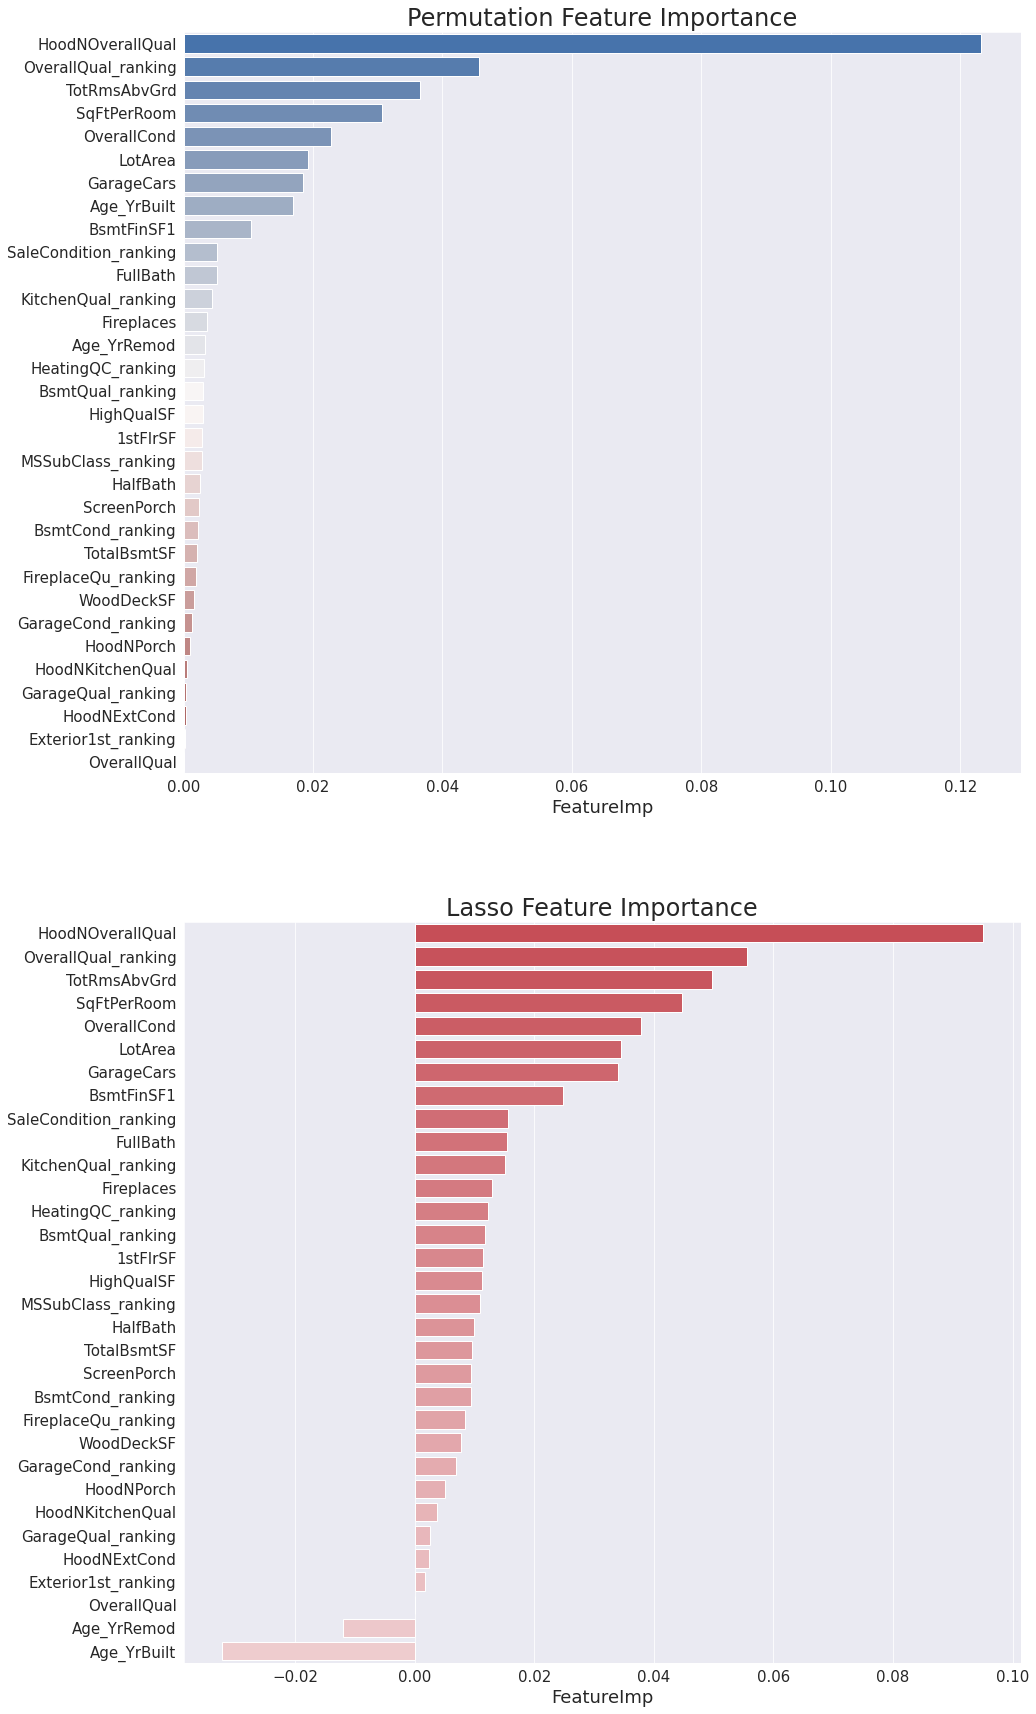

In [23]:
model = Lasso(alpha=0.01)
model.fit(X_train,y_train)

sns.set_context(rc={'xtick.labelsize': 15, 
                    'ytick.labelsize': 15,
                    'axes.labelsize' : 18, 
                    'axes.titlesize' : 24})

feature_imp = permutation_importance(model, X_train, y_train, n_repeats=10, n_jobs=-1, random_state=random_state)

perm_ft_imp_df = pd.DataFrame(data=feature_imp.importances_mean,columns=['FeatureImp'], index=X_train.columns).sort_values(by='FeatureImp', ascending=False)
model_ft_imp_df = pd.DataFrame(data=model.coef_,columns=['FeatureImp'], index=X_train.columns).sort_values(by='FeatureImp', ascending=False)

fig,ax = plt.subplots(2,1, figsize=(15,30))

perm_ft_imp_df_nonzero = perm_ft_imp_df[perm_ft_imp_df['FeatureImp']!=0]
model_ft_imp_df_nonzero = model_ft_imp_df[model_ft_imp_df['FeatureImp'] !=0]

sns.barplot(x=perm_ft_imp_df_nonzero['FeatureImp'], y=perm_ft_imp_df_nonzero.index, ax=ax[0], palette="vlag")
sns.barplot(x=model_ft_imp_df_nonzero['FeatureImp'], y=model_ft_imp_df_nonzero.index, ax=ax[1], palette=sns.diverging_palette(10, 220, sep=2, n=80))


ax[0].set_title('Permutation Feature Importance')
ax[1].set_title('Lasso Feature Importance')

plt.show()

Features like OverallQual, Neighborhood, GrLivArea and Year built rank high in our models, as one would expect. <br><br> What excites me is that some of the newly engineered features rank high in both lists.

# Hyperparameter optimizing with Optuna

As I am happy with the input data, I won't be making any further changes to it. <br>
Let's continue with model selection and hyperparameter optimization. <br>
<br> Due to high feature/low sample size of our data, there's a great chance of overfitting. Models with regularization mechanism such as Lasso and Ridge do well in regards to such data. In addition Lasso and Ridge, I'll use SVR, LGBM and RandomForest regressor. 
<br><br>
For hyperparameter tuning/optimization, I first used Optuna's search algorithm, then did a little manual tweaking to further increase the accuracy. <br> Optuna works similar to GridSearch algorithm. What I like more about this one is that it gives me the opportunity to set a "search range" instead of me having to declare values one by one for it to search from.<br> I also feel it works faster compared to GridSearch. <br><br> I am leaving hyperparameter search section commented out, since it takes a bit of time to run and leaves a long/ugly output. I stored the parameters in variables below.

In [24]:
# def objective(trial):
#     _C = trial.suggest_float('C',0.1,0.5)
#     _epsilon = trial.suggest_float('epsilon',0.01,0.1)
#     _coef = trial.suggest_float('coef0',0.5,1)

#     svr = SVR(cache_size=5000,kernel='poly',C=_C,epsilon=_epsilon,coef0=_coef)    

#     score = cross_val_score(svr,X_train,y_train,cv=cv,scoring='neg_root_mean_squared_error').mean()
#     return score

# optuna.logging.set_verbosity(0)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# svr_params = study.best_params
# svr_best_score = study.best_value
# print(f"Best score:{svr_best_score} \nOptimized parameters: {svr_params}")

In [25]:
# def objective(trial):

#     _alpha = trial.suggest_float('alpha',0.5,1)
#     _tol = trial.suggest_float('tol',0.5,0.9)
    
#     ridge = Ridge(alpha=_alpha,tol=_tol,random_state=random_state)  


#     score = cross_val_score(ridge,X_train,y_train,cv=cv,scoring='neg_root_mean_squared_error').mean()
#     return score

# optuna.logging.set_verbosity(0)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# ridge_params = study.best_params
# ridge_best_score = study.best_value
# print(f"Best score:{ridge_best_score} \nOptimized parameters: {ridge_params}")

In [26]:
# def objective(trial):

#     _alpha = trial.suggest_float('alpha',0.0001,0.01)
   
#     lasso = Lasso(alpha=_alpha,random_state=random_state)

#     score = cross_val_score(lasso,X_train,y_train,cv=cv,scoring='neg_root_mean_squared_error').mean()
#     return score

# optuna.logging.set_verbosity(0)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# lasso_params = study.best_params
# lasso_best_score = study.best_value
# print(f"Best score:{lasso_best_score} \nOptimized parameters: {lasso_params}")

In [27]:
# def objective(trial):
#     _n_estimators=trial.suggest_int('n_estimators',50,200)
#     _max_depth = trial.suggest_int('max_depth',5,12)
#     _min_samp_split = trial.suggest_int("min_samples_split",2, 8)
#     _min_samples_leaf = trial.suggest_int("min_samples_leaf", 3,6)
#     _max_features = trial.suggest_int("max_features",10,50)
    
#     rf = RandomForestRegressor(
#         max_depth=_max_depth,
#                                min_samples_split=_min_samp_split,
#                                ccp_alpha=_ccp_alpha,
#                                min_samples_leaf=_min_samples_leaf,
#                                max_features=_max_features,
#                                n_estimators=_n_estimators,
#                                n_jobs=-1, random_state=random_state)

#     score = cross_val_score(rf,X_train,y_train,cv=cv,scoring='neg_root_mean_squared_error').mean()
#     return score

# optuna.logging.set_verbosity(0)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# rf_params = study.best_params
# rf_best_score = study.best_value
# print(f"Best score:{rf_best_score} \nOptimized parameters: {rf_params}")

In [28]:
rf_params = {'max_depth': 8, 'max_features': 40,'n_estimators':132}
svr_params = {'kernel': 'poly', 'C': 0.053677105521141605, 'epsilon': 0.03925943476562099, 'coef0': 0.9486751042886584}
ridge_params ={'alpha': 0.9999189637151178, 'tol': 0.8668539399622242, 'solver': 'cholesky'}
lasso_params = {'alpha': 0.0004342843645993161, 'selection': 'random'}
lgbm_params={'num_leaves': 16, 'max_depth': 6, 'learning_rate': 0.16060612646519587, 'n_estimators': 64, 'min_child_weight': 0.4453842422224686}

# Model Comparison

Let's use cross-validate-score to help us see how different models perform.

In [29]:
cv = KFold(n_splits=4, random_state=random_state)

svr = SVR(**svr_params)
ridge = Ridge(**ridge_params, random_state=random_state)
lasso  = Lasso(**lasso_params, random_state=random_state)
lgbm = LGBMRegressor(**lgbm_params, random_state=random_state)
rf = RandomForestRegressor(**rf_params, random_state=random_state)
stack = StackingCVRegressor(regressors=[
    svr,
    ridge,
    lasso,
    lgbm,
    rf
],meta_regressor=LinearRegression(n_jobs=-1),
                            random_state=random_state,cv=cv,n_jobs=-1)

svr_scores = cross_val_score(svr,X_train,y_train, cv=cv, n_jobs=-1, error_score='neg_root_mean_squared_error')
ridge_scores = cross_val_score(ridge,X_train,y_train, cv=cv, n_jobs=-1, error_score='neg_root_mean_squared_error')
lasso_scores = cross_val_score(lasso,X_train,y_train, cv=cv, n_jobs=-1, error_score='neg_root_mean_squared_error')
lgbm_scores = cross_val_score(lgbm,X_train,y_train, cv=cv, n_jobs=-1, error_score='neg_root_mean_squared_error')
rf_scores = cross_val_score(rf,X_train,y_train, cv=cv, n_jobs=-1, error_score='neg_root_mean_squared_error')
stack_scores = cross_val_score(stack,X_train,y_train, cv=cv, n_jobs=-1, error_score='neg_root_mean_squared_error')


scores = [svr_scores,ridge_scores,lasso_scores,lgbm_scores,rf_scores,stack_scores]
models = ['SVR','RIDGE','LASSO','LGBM','RF','STACK']
score_medians = ([round(np.median([mean for mean in modelscore]),5) for modelscore in scores])

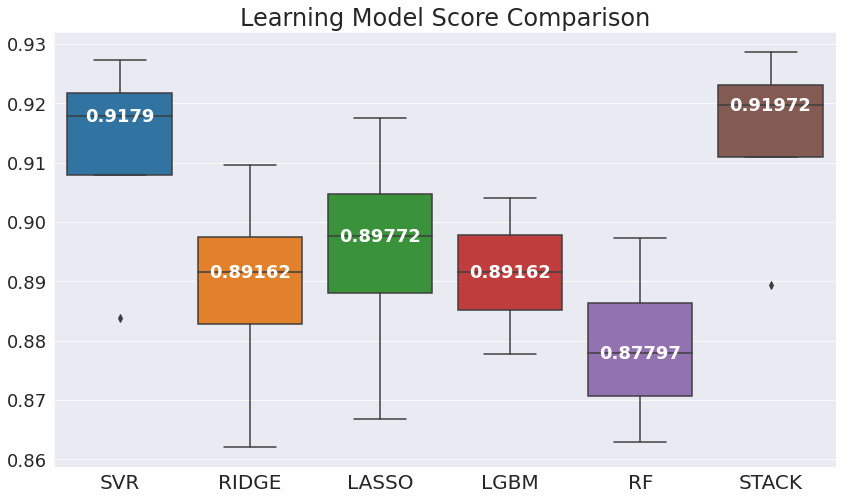

In [30]:
sns.set_style("darkgrid")
params = {
         'axes.labelsize': 30,
         'xtick.labelsize':20,
         'ytick.labelsize':18
}
plt.rcParams.update(params)

fig, ax = plt.subplots(figsize=(14,8))

vertical_offset = 0.001

ax.set_title('Learning Model Score Comparison')
bp = sns.boxplot(x=models, y=scores, ax=ax)


for xtick in bp.get_xticks():
    bp.text(xtick,score_medians[xtick] - vertical_offset,score_medians[xtick], 
            horizontalalignment='center',size=18, color='w',weight='semibold')
    
plt.show()

When I run the models, I see that the stacked model scores slightly better than SVR.<br> Even if the accuracy of one or two individual models rated higher than stacked model, I still would have picked stacked model.<br> This is because I believe that it will do a better job at generalizing/reduce impact of any overfitting compared to individual models. <br><br> Since we don't have a huge amount of data, the model runs quite fast! And it is ~92% accurate, I find this quite impressive.

# Final Submission

Below I submit the inverse log-transformed results.<br><br>

In [31]:
stack.fit(X_train.values,y_train.values)

predictions = stack.predict(X_test.values)
predictions = np.exp(predictions)

submission = pd.DataFrame({
        "Id": submission_ID,
        "SalePrice": predictions
    })
submission.to_csv('submission.csv', index=False)